In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import rv_continuous, norm, truncnorm, arcsine, chi2, gamma, triang, entropy
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from time import time

class glove_distribution_gen(rv_continuous):
    def _pdf(self,x):
        conds = [x<0, (x>=0) & (x<1), (x>=1) & (x<3), (x>=3) & (x<4), x>4]
        funcs = [0, 0.7, 0, 0.3, 0]
        return np.piecewise(x, conds, funcs)
    def _cdf(self,x):
        conds = [x<0, (x>=0) & (x<1), (x>=1) & (x<3), (x>=3) & (x<4), x>4]
        funcs = [0, lambda x: 0.7*x, 0.7, lambda x: 0.7+0.3*(x-3), 1]
        return np.piecewise(x, conds, funcs)
    def _stats(self):
        return 1.4, 1.973333333333333, None, None
glove_distribution = glove_distribution_gen(name='glove_distribution')

In [2]:
gift_df = pd.read_csv('gifts.csv')
gift_list = gift_df.GiftId.unique()
gift_types = ['horse', 'ball', 'bike', 'train', 'coal', 'book', 'doll', 'blocks', 'gloves']
gift_dist_list = [
    truncnorm(a=(0-5)/2, b=(50-5)/2, loc=5, scale=2),
    truncnorm((0-2)/0.3, (50-2)/0.3, loc=2, scale=0.3),
    truncnorm((0-20)/10, (50-10)/10, loc=20, scale=10),
    truncnorm((0-10)/5, (50-10)/5, loc=10, scale=5),
    arcsine(scale=47),
    chi2(2),
    gamma(5),
    triang(c = 1/3, loc=5, scale=15),
    glove_distribution]

gift_numbers = [1000, 1100, 500, 1000, 166, 1200, 1000, 1000, 200]
gift_ids = {
    'horse' : [],
    'ball'  : [],
    'bike'  : [],
    'train' : [],
    'coal'  : [],
    'book'  : [],
    'doll'  : [],
    'blocks' : [],
    'gloves': []
}
count = 0
for i, gt in enumerate(gift_types):
    n_gifts = gift_numbers[i]
    for j in range(count, n_gifts+count):
        gift_ids[gt].append(gift_list[j])
    count += n_gifts

In [3]:
gift_dists = {
    'horse' : truncnorm(a=(0-5)/2, b=(50-5)/2, loc=5, scale=2), #a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    'ball'  : truncnorm((0-2)/0.3, (50-2)/0.3, loc=2, scale=0.3),
    'bike'  : truncnorm((0-20)/10, (50-10)/10, loc=20, scale=10),
    'train' : truncnorm((0-10)/5, (50-10)/5, loc=10, scale=5),
    'coal'  : arcsine(scale=47),
    'book'  : chi2(2),
    'doll'  : gamma(5),
    'blocks' : triang(c = 1/3, loc=5, scale=15),
    'gloves': glove_distribution
}

toy_index = {
    0 : 'horse',
    1 : 'ball',
    2 : 'bike',
    3 : 'train',
    4 : 'coal',
    5 : 'book',
    6 : 'doll',
    7 : 'blocks',
    8 : 'gloves'  
}

In [4]:
def my_entropy(func, a, b, N): #compute the discretized entropy in bits
    t = np.linspace(a, b, N)
    probs = func(t)
    zeroes = [i for i,x in enumerate(probs) if np.allclose(0, x)]    
    return entropy(pk=probs, base=2)

entropy_list = []
for key, value in gift_dists.items():
    ent_i = my_entropy(value.pdf, 0, 50, 1000)
    if ent_i == -np.inf: ent_i = np.inf
    print('The entropy of \'%s\' is: %f bits' % (key, ent_i))
    entropy_list.append([key, ent_i])
entropy_list.sort(key=lambda x:x[1])

The entropy of 'ball' is: 4.630615 bits
The entropy of 'bike' is: 9.565264 bits
The entropy of 'blocks' is: 7.948717 bits
The entropy of 'gloves' is: 5.203219 bits
The entropy of 'coal' is: inf bits
The entropy of 'doll' is: 7.427448 bits
The entropy of 'train' is: 8.577619 bits
The entropy of 'book' is: 6.763217 bits
The entropy of 'horse' is: 7.327938 bits


In [5]:
entropy_list

[['ball', 4.6306146687859515],
 ['gloves', 5.203218994118056],
 ['book', 6.7632173632453085],
 ['horse', 7.327938365492245],
 ['doll', 7.4274484188697034],
 ['blocks', 7.9487171026363894],
 ['train', 8.5776189946749195],
 ['bike', 9.5652639177212659],
 ['coal', inf]]

In [6]:
total_weights = []
total = 0
for i,gt in enumerate(gift_types):
    average_weight = gift_dists[gt].mean()
    number_gifts = gift_numbers[i]
    weight = average_weight*number_gifts
    total_weights.append([gt, np.round(weight,2)])
    total+=weight
total

51034.745146271736

In [7]:
def plot_pdf(item, a, b, N):
    t = np.linspace(a, b, N)
    s = gift_dists[item].pdf(t)
    plt.plot(t, s)
    axes = plt.gca()

    if item == 'coal':
        ymin = 0
        ymax = 0.3
        axes.set_ylim([ymin,ymax])
    
    plt.figtext(1, 0.7, "Mean: %.2f\nVariance: %.2f\nEntropy: %.2f\nNumber of items: %d\nTotal weight: %.2f" % (gift_dists[item].mean(), gift_dists[item].var(),[i[1] for i in entropy_list if i[0]==item][0], len(gift_ids[item]),[i[1] for i in total_weights if i[0]==item][0]))
    
    plt.xlabel('weight (pounds)')
    plt.ylabel('PDF')
    plt.title(item)
    plt.grid(True)
    plt.savefig("test.png")
    plt.show()

In [8]:
def plot_cdf(item, a, b, N):
    t = np.linspace(a, b, N)
    s = gift_dists[item].cdf(t)
    plt.plot(t, s)
    axes = plt.gca()

    plt.figtext(1, 0.7, "Mean: %.2f\nVariance: %.2f\nEntropy: %.2f\nNumber of items: %d\nTotal weight: %.2f" % (gift_dists[item].mean(), gift_dists[item].var(),[i[1] for i in entropy_list if i[0]==item][0], len(gift_ids[item]),[i[1] for i in total_weights if i[0]==item][0]))
    
    plt.xlabel('weight (pounds)')
    plt.ylabel('CDF')
    plt.title(item)
    plt.grid(True)
    plt.savefig("test.png")
    plt.show()

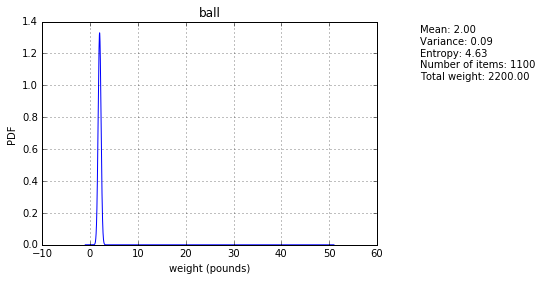

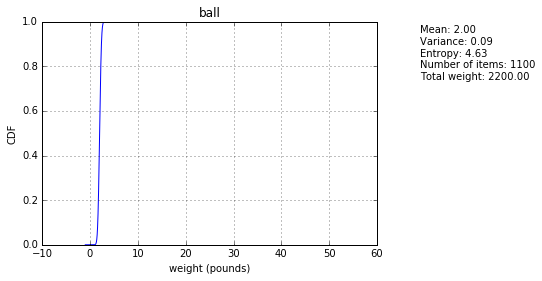

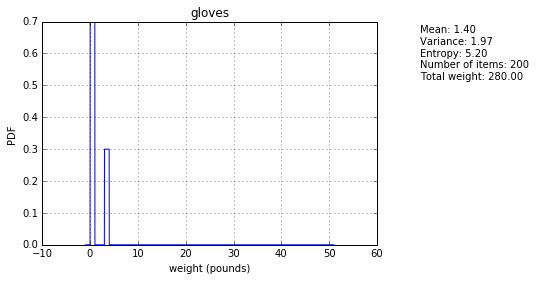

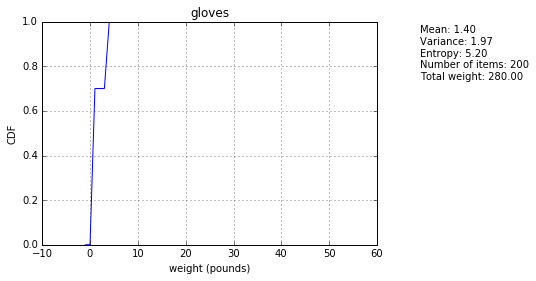

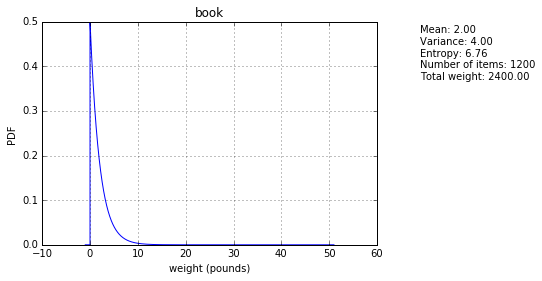

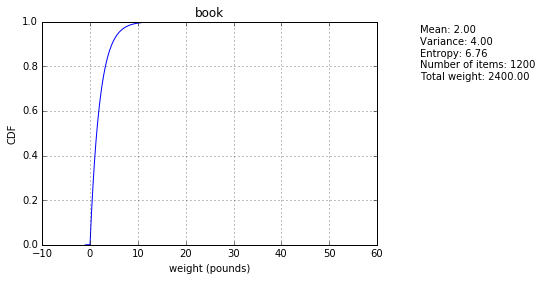

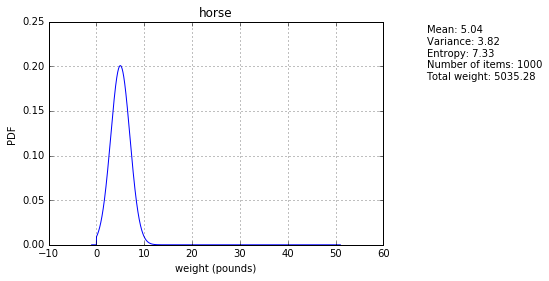

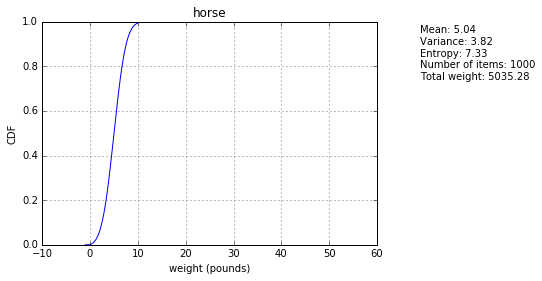

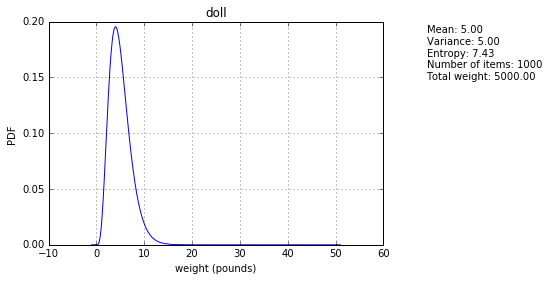

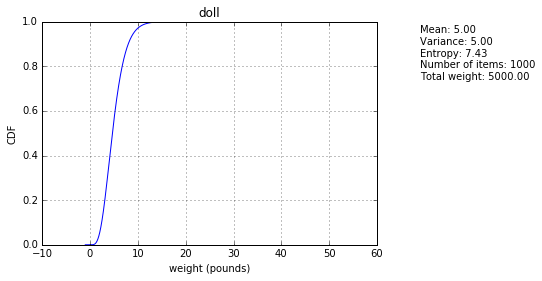

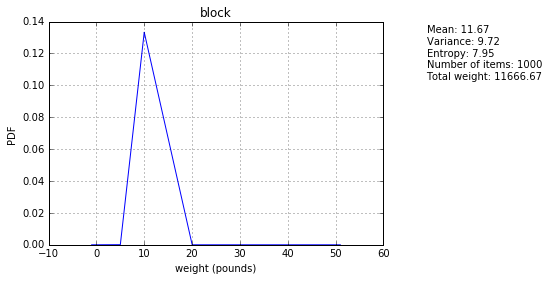

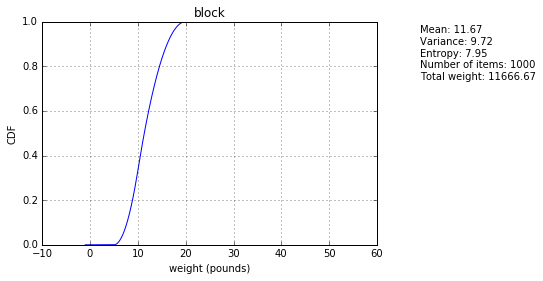

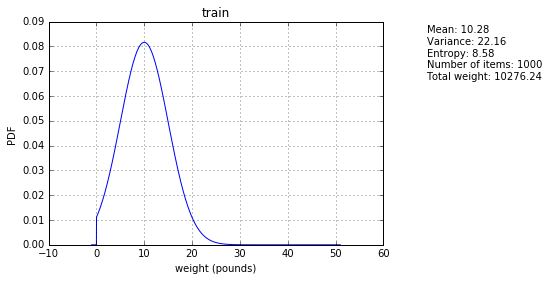

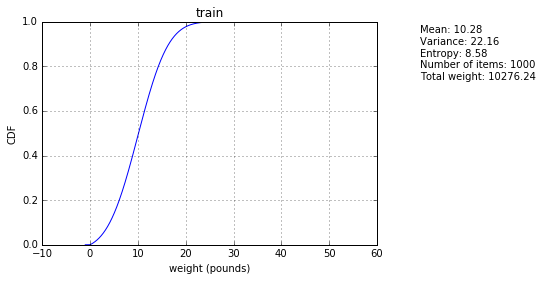

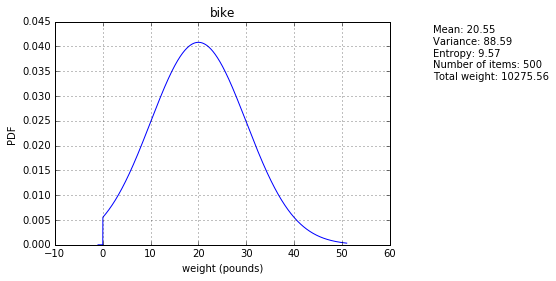

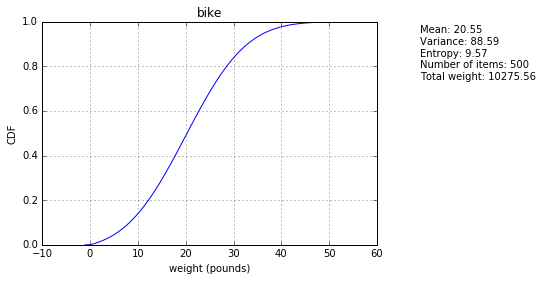

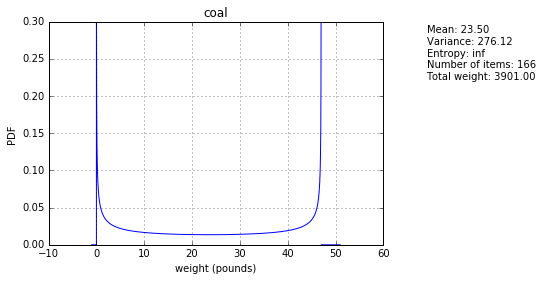

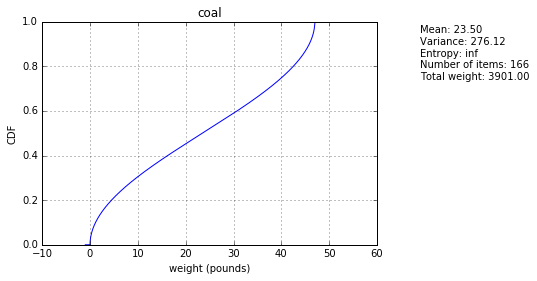

In [11]:
a = -1
b = 51
N = 1e6
for key, value in entropy_list:
    plot_pdf(key, a, b, N)
    plot_cdf(key, a, b, N)

In [10]:
first_try_score = 34730.58118
first_try = []
for i in range(1000):
    #1 ball, 1 book, 1 horse, 1 doll, 1 block and 1 train per package
    #200 packages get 1 glove
    #100 packages get 1 extra ball
    #200 packages get 1 extra book
    #no bikes nor coals for now
    package = ''
    package += gift_ids['ball'][i] 
    package += ' ' + gift_ids['book'][i] 
    package += ' ' + gift_ids['horse'][i] 
    package += ' ' + gift_ids['doll'][i] 
    package += ' ' + gift_ids['block'][i] 
    package += ' ' + gift_ids['train'][i] 
    if i<200:
        package += ' ' + gift_ids['gloves'][i] 
    elif i < 200+100:
        package += ' ' + gift_ids['ball'][i-200+1000] 
    elif i<200+100+200:
        package += ' ' + gift_ids['book'][i-200-100+1000] 
    first_try.append(package)

In [11]:
columns = ['Gifts']
first_try_df = pd.DataFrame(first_try)
first_try_df.columns = columns

In [12]:
first_try_df.to_csv('first_try.csv', index=False)

In [13]:
first_try_df

,Gifts
0,ball_0 book_0 horse_0 doll_0 blocks_0 train_0 ...
1,ball_1 book_1 horse_1 doll_1 blocks_1 train_1 ...
2,ball_2 book_2 horse_2 doll_2 blocks_2 train_2 ...
3,ball_3 book_3 horse_3 doll_3 blocks_3 train_3 ...
4,ball_4 book_4 horse_4 doll_4 blocks_4 train_4 ...
5,ball_5 book_5 horse_5 doll_5 blocks_5 train_5 ...
6,ball_6 book_6 horse_6 doll_6 blocks_6 train_6 ...
7,ball_7 book_7 horse_7 doll_7 blocks_7 train_7 ...
8,ball_8 book_8 horse_8 doll_8 blocks_8 train_8 ...
9,ball_9 book_9 horse_9 doll_9 blocks_9 train_9 ...


0.998653577124
0.997652939242
0.67867704561
0.0200799117917
6.3031670061e-08
2.56615207955e-11
1.21635575894e-09


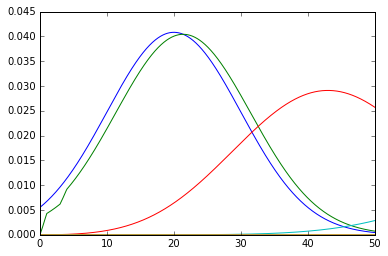

In [22]:
delta = 0.001
x = np.arange(0, 50, delta)
f1 = gift_dists['bike'].pdf(x)
f2 = gift_dists['gloves'].pdf(x)
y1 = np.convolve(f1,f2)*(delta) #PDF of the weight of two items
y1 = y1[0:len(x)]
y2 = np.convolve(y1,y1)*(delta) #PDF of the weight of four items
y2 = y2[0:len(x)]
y3 = np.convolve(y2,y2)*(delta) #PDF of the weight of eight items
y3 = y3[0:len(x)]
y4 = np.convolve(y3,y3)*(delta) #PDF of the weight of sixteen items
y4 = y4[0:len(x)]
y5 = np.convolve(y4, y2)*(delta) #PDF of the weight of twenty items
y5 = y5[0:len(x)]
plt.plot(x,f1,x,y1,x,y2,x,y3,x,y4,x,y5)
print(sum(f1)*delta)
print(sum(y1)*delta)
print(sum(y2)*delta)
print(sum(y3)*delta)
print(sum(y4)*delta)
print(sum(y5)*delta)

print(sum([xi*fi for xi, fi in zip(x,y5)])*delta)

0.468728044034
0.0702140036233
0.00934919060697
0.00116706640362
0.000139858334888

-----
0.0998645938614
9.91903084315e-07


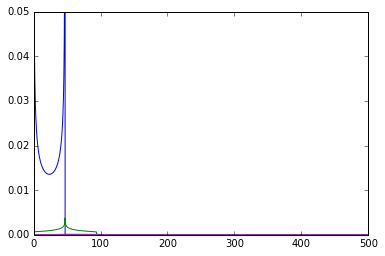

In [27]:
def no_inf_pdf(dist, x):
    delta = x[1] - x[0]
    #get the distribution in the range
    dist_pdf = dist.pdf(x)
    #get all the infinities
    inf_index = np.where(dist_pdf == np.inf)[0]
    #check if there are any infinities
    if len(inf_index) == 0:
        return dist_pdf #no infinities, phew
    #treat infinities
    for i in inf_index:
        xi = x[i]
        dist_pdf[i] = (dist.cdf(xi + delta/2) - dist.cdf(xi - delta/2))/delta #hoping that there is a closed expression for the cdf
    return dist_pdf #no more infinities, phew    


#delta = 0.01
N = 5001
a = 0
b = 50
delta = (b-a)/(N-1)
x = np.linspace(0, 500, N)
item = 'coal'
y = f = no_inf_pdf(gift_dists[item],x)
N = 5
max_ev = 0
plt.hold(True)
axes = plt.gca()
if item == 'coal':
        ymin = 0
        ymax = 0.05
        axes.set_ylim([ymin,ymax])

for i in range(N):
    plt.plot(x,y)
    g = y
    y = np.convolve(f,y)*(delta) #PDF of the weight of two items
    y = y[0:len(x)]
    expected_value = sum([xi*yi for xi, yi in zip(x,y)])*delta
    print(expected_value)
    #if expected_value > max_ev:
    #    max_ev = expected_value
    #    print(max_ev)
    #else:
    #    print(expected_value)
    #    break
            
#plt.plot(x,f,x,g,x,y)
print('\n-----')
print(sum(f)*delta)
print(sum(y)*delta)


In [15]:
#def isiterable(obj):
#    try:
#        iter(obj)
#    except TypeError:
#        return False 
#    else:
#        return True
#
#class combination:
#    def __init__(self, combination, items = None):
#        #combination = {items : quantity}
#        #items = [first_item, second_item, ...]"
#        if items == None:
#            self.full_dict = False
#            if combination == None:
#                self.comb = {}
#            elif type(combination) == dict:
#                self.comb = combination_dictionary
#            elif isiterable(combination):
#                d = {}
#                for i in combination:
#                    if i in d:
#                        d[i] +=1
#                    else:
#                        d[i] = 1
#                self.comb = d
#        else:
#            self.full_dict = True
#            self.comb = dict(zip(items, [0] * len(items)))
#            for i in combination:
#                self.comb[i] += 1
#    
#    def __repr__(self):
#        return str(self.get_list())
#    
#    def get_list(self):
#        out = []
#        for key, value in self.comb.items():
#            for i in range(value):
#                out.append(key)
#        return sorted(out)
#    
#    def contains(self, other):
#        #checks if self contains other combination
#        self_d = self.comb.copy()
#        
#        if not self.full_dict:
#            for otherkey in other.comb:
#                if otherkey not in self_d:
#                    self_d[otherkey] = 0
#        
#        for item, qty in self_d.items():
#            if item not in other.comb: other.comb[item] = 0
#            elif self_d[item] < other.comb[item]: return False
#        return True
#    
#    def distance(self, other):
#    
#    def get_comb(self):
#        return self.comb
#    
#    def get_str(self):
#        return self.__repr__()
#
#def isvalid(comb, rules_list):
#    #returns True if combination is valid according to the rules
#    #print('combination = %s' % (comb.get_str()))
#    for rule in rules_list:
#        if comb.contains(rule):
#            return False
#    return True

In [19]:
now = time()
items = 'ABCDEFGHI'
rules_list = [combination(i, items) for i in ['A', 'BC', 'GGH', 'BF', 'BH', 'F']]
output = []
for i in combinations_with_replacement(items, 10):
    if test_isvalid(combination(i, items), rules_list):
        output.append(list(i))
print(len(output))
print('Time elapsed: %.2f s' % (time()- now))

NameError: name 'combination' is not defined

In [31]:
def isiterable(obj):
    try:
        iter(obj)
    except TypeError:
        return False 
    else:
        return True

class combination:
    def __init__(self, iterable, items = None):
        #combination = {items : quantity}
        #items = [first_item, second_item, ...]
        self.length = 0
        if items == None:
            raise Exception('items must be provided.')
        else:
            self.comb = dict(zip(sorted(items), [0] * len(items)))
            for i in iterable:
                self.comb[i] += 1
                self.length += 1
        self.key = frozenset(self.comb.items())
    
    def __eq__(self, other):
        """Override the default Equals behavior"""
        if isinstance(other, self.__class__):
            return self.__dict__ == other.__dict__
        return NotImplemented
    
    def __ne__(self, other):
        """Define a non-equality test"""
        if isinstance(other, self.__class__):
            return not self.__eq__(other)
        return NotImplemented
    
    def __hash__(self):
        """Override the default hash behavior (that returns the id or the object)"""
        return hash(self.key)
    
    def __repr__(self):
        return str(self.get_list())
    
    def get_len(self):
        return self.length
    
    def get_list(self):
        out = []
        for key, value in self.comb.items():
            for i in range(value):
                out.append(key)
        return sorted(out)
    
    def contains(self, other):
        #checks if self contains other combination
        self_d = self.comb.copy()
        
        for item, qty in self_d.items():
            if item not in other.comb: other.comb[item] = 0
            elif self_d[item] < other.comb[item]: return False
        return True
    
    def distance(self, other):
        d = 0
        for key in self.comb:
            d += np.absolute(self.comb[key] - other.comb[key])
        return d
    
    def difference(self, other):
        #self must contain other
        if not self.contains(other):
            raise Exception('Self must contain other.')
        dif = []
        items = [i for i in self.comb]
        for key in self.comb:
            for i in range(self.comb[key] - other.comb[key]):
                dif.append(combination([key], items))
        return dif
    
    def get_comb(self):
        return self.comb
    
    def get_str(self):
        return self.__repr__()

def test_isvalid(comb, rules_list):
    #returns True if combination is valid according to the rules
    #print('combination = %s' % (comb.get_str()))
    for rule in rules_list:
        if comb.contains(rule):
            return False
    return True

In [53]:
class convolutions_galore:
    def __init__(self, distribution_names, distributions, N=201, limits=[0, 50]):
        self.keys = distribution_names
        self.x = np.linspace(limits[0], limits[1], N)
        self.delta = (limits[1]-limits[0])/(N-1)
        self.packs_pdfs = {}
        self.rules = []
        for index, item in enumerate(self.keys):
            dist_pdf = self._no_inf_pdf(distributions[index])
            dist_pdf = self._kill_trailing_zeroes(dist_pdf)
            self.packs_pdfs[combination([item], self.keys)] = [self._expected_score(dist_pdf), np.asarray(dist_pdf)]

    def _cut_pdf(self, pdf):
        n = len(self.x)
        if len(pdf) <= n:
            return pdf
        else:
            return pdf[0:n]
    
   
    @staticmethod
    def _kill_trailing_zeroes(mahlist):
        for i in reversed(range(len(mahlist))):
            if mahlist[i] <= 1e-50:
                pass
            else:
                mahlist = mahlist[:i+1]
                break
        return mahlist
    
    
    def _no_inf_pdf(self, dist):
        #get the distribution in the range
        dist_pdf = dist.pdf(self.x)
        #get all the infinities
        inf_index = np.where(dist_pdf == np.inf)[0]
        #check if there are any infinities
        if len(inf_index) == 0:
            return dist_pdf #no infinities, phew
        #treat infinities
        for i in inf_index:
            xi = self.x[i]
            dist_pdf[i] = (dist.cdf(xi + self.delta/2) - dist.cdf(xi - self.delta/2))/self.delta #hoping that there is a closed expression for the cdf
        return dist_pdf #no more infinities, phew    
    
    
    def _expected_score(self,pdf):
        es = 0
        pdf = self._cut_pdf(pdf)
        for index, y in enumerate(pdf):
            es += self.x[index] * y
        return es * self.delta
    
    
    def _find_lowest_distance_key(self, new_combination):
        #find the key with the lowest distance to the new combination
        lowest_distance = np.inf
        closest_key = None 
        for key in self.packs_pdfs:
            d = key.distance(new_combination)
            if d <= 1:
                return key, d
            elif  d < lowest_distance:
                lowest_distance = d
                closest_key = key
        return closest_key, d
    

    def _add_new_rule(self, new_combination):
        self.rules.append(new_combination)
    
    
    def _isvalid(self, new_combination):
        #returns True if combination is valid according to the rules
        for rule in self.rules:
            if new_combination.contains(rule):
                return False
        return True
    
    
    def add_new_convolution(self, new_combination):
        [closest_key, closest_distance] = self._find_lowest_distance_key(new_combination)
        
        if closest_distance == 0:
            return
        
        differences = new_combination.difference(closest_key)
        [old_score, old_package_pdf] = self.packs_pdfs[closest_key]
        new_package_pdf = old_package_pdf
        
        for key in differences:
            item_pdf = self.packs_pdfs[key][1]
            new_package_pdf = np.convolve(new_package_pdf, item_pdf)*self.delta
            new_package_pdf = self._kill_trailing_zeroes(new_package_pdf)
            
        new_score = self._expected_score(new_package_pdf)
        
        if new_score > old_score:
            self.packs_pdfs[new_combination] = [new_score, new_package_pdf]
        else:
            self._add_new_rule(new_combination)
    
    def find_all_valid_convolutions(self, depth=5):
        then = time()
        for i in range(1, depth+1):
            print('Time elapsed: %.2f\nCombination size: %d\n---' % (time()-then, i))
            k = 0
            for c in [combination(j, self.keys) for j in combinations_with_replacement(self.keys, i)]:
                if self._isvalid(c):
                    self.add_new_convolution(c)
                if k%10000 == 0:
                    if time()-then > 30000:
                        return

In [ ]:
then = time()
a = convolutions_galore(gift_types, gift_dist_list, N=5001)
a.find_all_valid_convolutions(25)
for key, value in a.packs_pdfs.items():
    #print('Combination = %s, Score = %.2f' % (key, value[0]))
    pass
print('Time elapsed: %.2f' % (time()-then))

Time elapsed: 0.00
Combination size: 1
---
Time elapsed: 0.00
Combination size: 2
---
Time elapsed: 0.32
Combination size: 3
---
Time elapsed: 1.73
Combination size: 4
---
Time elapsed: 5.81
Combination size: 5
---
Time elapsed: 15.45
Combination size: 6
---
Time elapsed: 34.21
Combination size: 7
---


In [51]:
b = [[key, value[0], sum(value[1])*a.delta] for key, value in a.packs_pdfs.items()]
b.sort(key = lambda x: x[1])
print('Number of combinations: %d' % (len(a.packs_pdfs.items())))
print('Number of rules: %d' % (len(a.rules)))

Number of combinations: 390
Number of rules: 51


In [95]:
b[-20:-1]

[[['book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'gloves'],
  41.650942250473548,
  1.2674477219883369],
 [['ball', 'ball', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book'],
  41.65252095447547,
  1.251735830247426],
 [['book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book'],
  41.664441735496233,
  1.2674477219883364],
 [['ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'book', 'horse', 'horse'],
  41.709219125287952,
  1.0129939608169947],
 [['ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'ball', 'horse', 'horse', 'horse'],
  41.724104671111661,
  1.000654671

In [96]:
convolutions = pd.DataFrame(a.packs_pdfs, index=['score', 'pdf']).transpose()

In [97]:
convolutions = convolutions.sort_values('score')

In [98]:
#convolutions.to_csv('other_convolutions_1001_20.csv', columns=['combinations', 'score'])

In [99]:
convolutions.iloc[:,0]

['gloves']                                                                                                                                                                 1.375
['book']                                                                                                                                                                  1.9999
['ball']                                                                                                                                                                       2
['gloves', 'gloves']                                                                                                                                                        2.75
['ball', 'gloves']                                                                                                                                                         3.375
['book', 'gloves']                                                                                                 